## Introduction

The purpose of this lab is to learn how to use the ADALM-2000 to generate signals and monitor them with its scopes. We will familiarize ourselves with lab instruments. First, the oscilloscope, to verify that the produced waveforms are correct. Then, the FieldFox RF Analyzer to view their spectrum.

## Oscilloscope Exercises

### Exercise 1.1: Generating Sinusoidal Samples using the ADALM-2000 and Measuring on the Oscilloscope

In this exercise, we will generate a discrete sinusoid with the ADALM-2000 and use our oscilloscope to observe it.

#### Block Diagram

Connect the ADALM-2000 to the oscilloscope and the host computer as shown below.

<figure>
<img src="Images/ADALM to Scope Wiring BD.jpg" width="500">
<figcaption align = "center"></figcaption>
</figure>

<figure>
<img src="Images/ADALM to Scope Wiring.jpg" width="700">
<figcaption align = "center"></figcaption>
</figure>

Set the input impedance of the oscilloscope to 50 $\Omega$. Then run the code cell below, which will generate samples corresponding to a sinusoid and use the DAC on the ADALM-2000 to generate a corresponding waveform.

In [86]:
# import necessary libraries
import libm2k
import numpy as np
import math
import time
import matplotlib.pyplot as plt


# define global parameters
fs_out = 75e06		# output(DAC) sampling rate in HZ
Ts_out = 1.0 / fs_out	# sampling period in seconds
fm_s = 250e03		# sinusoidal wave frequency in HZ
Tm_s = 1.0 / fm_s		# period of the sinusoidal wave in seconds

Nb_periods = 10

# generate samples
t=np.arange(0,Nb_periods*Tm_s,Ts_out)
buffer = 0.25*np.sin(2*np.pi*fm_s*t)


# check that the hardware is plugged in
uri = libm2k.getAllContexts()
if(len(uri) == 0):
    libm2k.contextCloseAll()

# open the hardware and calibrate it
ctx=libm2k.m2kOpen()
ctx.calibrateDAC()
aout=ctx.getAnalogOut()


# configure the output channel on the ADALM-2000
channel = 0	# 0 or 1 corresponding to I or Q
aout.setSampleRate(channel, fs_out)
aout.enableChannel(channel, True)
aout.setCyclic(True)

# push the data to the ADALM-2000
aout.push(channel,buffer)

#### Question 1.1a:

What amplitude (half of peak-to-peak) do you read on the oscilloscope? Feel free to use the measure button.

*ANSWER:*

$V_{25\text{kHz}} = [0.3]$ V


#### Question 1.1b:

Convert that quantity into dBm for a load impedance of 50 $\Omega$.

*ANSWER:*

$V_{25\text{kHz}} = 10log((\frac{0.3}{\sqrt{2})^2 / 50) = [-0.45]$ dBm

### Exercise 1.2: Reading the Address of the Oscilloscope via PyVISA

In order to better document your responses in labs, you will periodically attach screenshots from the lab instruments to your lab report. This will be easy to do: with the help of special libraries, Python scripts can capture screenshots from testing equipment and store them on your local director. After that, you add a Markdown cell include the image in your Jupyter Noteboook.

The library that interfaces with instruments in your lab is called VISA or Virtual Instrument Software Architecture. It can control settings on the instruments and export data from them.
PyVISA (https://pyvisa.readthedocs.io/) is a
Python library that implements the VISA API and supports a number of
instruments.

When you set parameters on an instrument, it is a good idea to read them back
into your program on your computer and print them out at each step. You will
also want to look at the displays on the lab instrument to confirm that it is
responding to the control commands correctly. For those
familiar with software development, such verification steps are analogous to
"unit tests."

Run the following code cell to print out the addresses of the instruments
connected to your computer.

In [28]:
import pyvisa as visa

rm = visa.ResourceManager("C:\\Windows\\System32\\visa64.dll")
print(rm.list_resources())
rm.close()

('GPIB1::17::INSTR', 'USB0::0x2A8D::0x1778::MY59241120::0::INSTR', 'USB0::0x2A8D::0x5C18::MY59221093::0::INSTR')


Other ways to obtain the instrument address include:

- On oscilloscope front panel, go to utility->I/O, read the USB VISA address
  such as 'usb0::10893::6008::MY59241110::INSTR'.

- On the host computer, open Keysight Connection Expert. You can read the
  oscilloscope and FieldFox USB VISA address.

Save your instrument addresses in the cell below.

*ANSWER:*

[Oscilloscope: MY59241120]

### Exercise 1.3: Reading the Oscilloscope Settings via PyVISA

The code cell below reads and prints the current settings from the oscilloscope. You will have to slightly modify it to use the address of the oscilloscope connected to your computer. To do this, copy and paste the address that you obtained in Exercise 1.2 in place of the string in the variable <code>VISA_ADDRESS</code>. Then run the code cell and answer the questions that follow.

In [51]:
# sample code which works for Keysight Oscilloscope MSOX3014T
import pyvisa as visa
import sys

# try to connect to the oscilloscope and exit upon failure
rm = visa.ResourceManager("C:\\Windows\\System32\\visa64.dll")
try:
    VISA_ADDRESS = "USB0::0x2A8D::0x1778::MY59241120::0::INSTR"  # set the resource string for your instrument
    inst = rm.open_resource(VISA_ADDRESS)  # open the connection
except visa.Error as ex:
    print('Couldn\'t connect to \'%s\', exiting now...' % VISA_ADDRESS)
    sys.exit()

# configure the instrument interface
inst.InputBufferSize = 1000000 # set the buffer size
inst.ByteOrder = 'littleEndian' # set the Byte order
inst.timeout = 10000 # set the timeout value

# Now control the instrument using SCPI commands.
# Refer to the instrument programming manual for your instrument for the correct SCPI commands for your instrument.

# write a query request to find the time scale
inst.write('TIMebase:SCALe?')
# read the query response
time_scale = float(inst.read())
print('time scale is ' + str(time_scale) + ' s/div')

# write a query request to find the vertical scale
inst.write('CHANnel1:SCALe?')
# read the query response
vertical_scale = float(inst.read())
print('vertical scale is ' + str(vertical_scale) + ' v/div')

# write a query request to find the offset on channel 1
inst.write('CHANnel1:OFFSet?')
# read the query response
offset = float(inst.read())
print('offset is ' + str(offset) + ' v')

inst.write('CHANnel1:COUPling?')
# read the query response
coupling = str(inst.read())
print('The coupling is ' + coupling)

inst.write('CHANnel1:IMPedance?')
# read the query response
impedance = str(inst.read())
print('input impedance is ' + impedance)

# close the VISA connection
inst.close()
rm.close()

time scale is 0.00075 s/div
vertical scale is 0.1 v/div
offset is 0.0 v
The coupling is DC

input impedance is ONEM



#### Question 1.3a:

What do DC and AC coupling mean?

*ANSWER:*

[DC: oscilloscope input is being directly measured. AC: oscilloscope input is filtered through capacitor to remove low frequency dc offset. It centers periodic signals around 0.]


#### Question 1.3b:

If you want to measure the DC component of a signal on the oscilloscope, do you want to select DC or AC coupling?

*ANSWER:*

[DC coupling]

### Exercise 1.4: Configuring the Oscilloscope Settings via PyVISA

The code cells below configure some of the key parameters on the oscilloscope.

#### Question 1.4a:

Given that the signal of interest is a tone (i.e. a sinusoid) with a frequency of 250 kHz, what would should be the time scale on the oscilloscope? Please enter your value in the code cell below.

*ANSWER:*

In [9]:
time_scale = 2e-6

#### Question 1.4b:

Remember to change the <code>VISA_ADDRESS</code> in the code below, and run the code cell below to set the parameters. The time_scale used is the one you entered in Question 1.4a.

In [10]:
# sample code which works for Keysight Oscilloscope MSOX3014T
import pyvisa as visa
import sys

rm = visa.ResourceManager("C:\\Windows\\System32\\visa64.dll")
try:
    VISA_ADDRESS = "USB0::0x2A8D::0x1778::MY59241120::0::INSTR"  # set the resource string for your instrument
    inst = rm.open_resource(VISA_ADDRESS)  # open the connection
except visa.Error as ex:
    print('Couldn\'t connect to \'%s\', exiting now...' % VISA_ADDRESS)
    sys.exit()

inst.InputBufferSize = 1000000 # set the buffer size
inst.ByteOrder = 'littleEndian' # set the Byte order
inst.timeout = 10000 # set the timeout value

# now control the instrument using SCPI commands.
# refer to the instrument programming manual for your instrument for the correct SCPI commands for your instrument.
vertical_scale = 5e-1
offset = 0
coupling = 'DC'
impedance = 'ONEMeg'# The other option 'FIFTy'
#inst.write('*RST; AUTOSCALE') # Reset the instrument and autoscale
inst.write('TIMebase:SCALe ' + str(time_scale)) # set time base s/div
inst.write('CHANnel1:SCALe ' + str(vertical_scale)) # set vertical scale v/div
inst.write('CHANnel1:OFFSet ' + str(offset)) # set offset
inst.write('CHANnel1:COUPling ' + coupling) # set coupling
inst.write('CHANnel1:IMPedance ' + impedance) # set impedance

# close the VISA connection
inst.close()
rm.close()

Were the scope parameters changed appropriately?

*ANSWER:*

[Yes]

### Exercise 1.5: Capturing an Oscilloscope Screenshot via PyVISA

The program below will take a screenshot of the scope and store it in your
working directory as a .png file with the title defined in the program. In our
example, the name of the screenshot is "oscope_screen.png". Please note that if you run the program without changing the file name, it will overwrite your previous file without any warning.

Run the code cell below to generate the screenshot image in the local directory.

In [11]:
# screen shot sample code which works for Keysight Oscilloscope MSOX3014T
import pyvisa as visa
import sys

rm = visa.ResourceManager("C:\\Windows\\System32\\visa64.dll")
try:
    VISA_ADDRESS = "USB::0x2A8D::0x1778::MY59241120::INSTR"  # set the resource string for your instrument
    inst = rm.open_resource(VISA_ADDRESS)  # open the connection
except visa.Error as ex:
    print('Couldn\'t connect to \'%s\', exiting now...' % VISA_ADDRESS)
    sys.exit()
inst.timeout = 10000 # set the timeout value
capture = inst.query_binary_values('DISPLAY:DATA? PNG', container = list, datatype = 'c')

with open("oscope_screen.png", "wb") as fp:
    for byte in capture:
        fp.write(byte)

# Close the VISA connection
inst.close()
rm.close()

To attach the picture to your lab submission (i.e. this Jupyer Notebook), execute the cell below and the plot should pop up. If it does not, check that a picture file named "oscope_screen.png" is in fact in the current directory. If the file does exist, you may need to save the notebook and refresh Jupyter.

*ANSWER:*

<figure>
<img src="oscope_screen.png" width="700">
<figcaption align = "center"></figcaption>
</figure>

## ADALM-2000 Exercises

### Exercise 1.6: Pushing Non-Cyclic Buffers using ADALM-2000

You may have noticed at the end of the Python program in Exercise 1.1 that there
is a function call <code>aout.setCyclic(True)</code>. When the Cyclic mode is set to be True, we
push our data samples to ADALM only once, and it will repeatedly generate the same signal by cycling through the samples contained in its internal buffer. As you continued to work Exercises 1.2-1.5, the ADALM-2000 kept generating that sinusoidal signal on its own, and it was displayed on the oscilloscope.
Cyclic mode is the ideal if we
would like to send periodic signals such as sinusoidal waves. In this exercise,
we are going observe what happens if we push sinusoidal samples in non-cyclic
mode.

First, whenever we are done generating a signals in the ADALM-2000, it is a best practice from a software point of view to close the interface to the hardware. Assuming we have previously called <code>ctx=libm2k.m2kOpen()</code>, we can close the interface to the hardware by executing the code cell below.

In [49]:
libm2k.contextClose(ctx)

Notice that the sinusoid from Exercises 1.1-1.5 should disappear from the oscilloscope after your execute this code cell.


Now we are going to use the following code cell to generate something aside from a periodic sinusoid. In particular, the code cell below generates short bursts of a sinusoid separated in time.

In [ ]:
import libm2k
import numpy as np

# define global parameters
fs_out = 75e06		# output(DAC) sampling rate in Hz
Ts_out = 1.0 / fs_out	# sampling period in seconds
fm_s = 250e03		# sinusoidal wave frequency in Hz
Tm_s = 1.0 / fm_s   	# period of the sinusoidal wave in seconds

# check that the hardware is plugged in
uri = libm2k.getAllContexts()
if(len(uri) == 0):
    libm2k.contextCloseAll()

# open the hardware and calibrate it
ctx=libm2k.m2kOpen()
ctx.calibrateDAC()

# connect and configure analog output
aout=ctx.getAnalogOut()
aout.setSampleRate(0, fs_out)
aout.enableChannel(0, True)
aout.setCyclic(False)

# compute a an integer number of periods of the sinusoid
# with total buffer size less than 4M samples
Nb_periods=math.floor(4e6/fs_out/Tm_s)

print("seconds", Nb_periods * Tm_s)

# generate samples
t=np.arange(0,Nb_periods*Tm_s,Ts_out)
print("samples", len(t))
buffer = 0.25*np.sin(2*np.pi*fm_s*t)

i = 0
while(i < 30):
    # continuously push the non-cyclic buffer to channel 0 of the output
    aout.push(0,buffer) 
    time.sleep(1.0)
    i += 1

seconds 0.053332
samples 3999900


#### Question 1.6a:

How long is the burst of a sinusoid is generated based on the code above?

*ANSWER:*

Samples = [3999900]

Seconds = [0.053332]

#### Question 1.6b:

Now we will measure the duration of the sinusoidal pulse with the oscilloscope.

Run the code cell above to generate 30 non-cyclic sinusoidal pulses seperated by 1 second intervals. Press the 'Single' button on the scope front panel to capture only one of the pulses. To ensure that the pulse is captured in its entirety, adjust the horizontal scale appropriately. (Given the durations and sample rates, consider what the minimum horizontal scale should be to see a pulse.)

If you can't observe the waveform on the oscilloscope, check that the Trigger level is set at around 200 mV (to trigger on the pulse) and that "Trigger Type" is set to "Edge" (its default value). 


Each sinusoidal pulse should have the same duration as the one you calculated in the Question 1.6b. To confirm this, attach a screenshot to your lab submission. The code below creates it, but once again remember to change he address of your oscilloscope in the <code>VISA_ADDRESS</code> variable.

In [ ]:
# screen shot sample code which works for Keysight Oscilloscope MSOX3014T
import pyvisa as visa
import sys

rm = visa.ResourceManager("C:\\Windows\\System32\\visa64.dll")
try:
    VISA_ADDRESS = "USB0::0x2A8D::0x1778::MY59241120::0::INSTR"  # set the resource string for your instrument
    inst = rm.open_resource(VISA_ADDRESS)  # open the connection
except visa.Error as ex:
    print('Couldn\'t connect to \'%s\', exiting now...' % VISA_ADDRESS)
    sys.exit()
inst.timeout = 10000 # set the timeout value
capture = inst.query_binary_values('DISPLAY:DATA? PNG', container = list, datatype = 'c')

with open("non-cyclic_buf.png", "wb") as fp:
    for byte in capture:
        fp.write(byte)

# Close the VISA connection
inst.close()
rm.close()

*ANSWER:*

<figure>
<img src="non-cyclic_buf.png" width="700">
<figcaption align = "center"></figcaption>
</figure>

This measurement IS  consistent with the predicted time duration of the sinusoid pulse from Exercise 1.6a.

_Note_: Once you have completed this exercise, you should again free up the hardware interface by executing the code cell below.

In [15]:
libm2k.contextClose(ctx)

### Exercise 1.7: Measuring and Plotting Signals using the ADALM-2000

Instead of the oscilloscope, we can use the ADC channels of the ADALM-2000 to measure and plot signals as well.

#### Block Diagram

Connect one DAC output of the ADALM-2000 to one of its ADC inputs as shown in the block diagram and photo below.

<figure>
<img src="Images/ADALM to ADALM Wiring BD.png" width="1000">
<figcaption align = "center"></figcaption>
</figure>

Your wiring should be similar to that in the picture below.

<figure>
<img src="Images/ADALM to ADALM Wiring.jpg" width="400">
<figcaption align = "center"></figcaption>
</figure>

After making the hardware connection shown above, please run the following four code cells. We have broken the program for this exercise down into multiple code cells to make it easier to copy and paste functionality into other exercises going forward.

In [21]:
# import necessary libraries
import libm2k
import numpy as np
import math
import time
import matplotlib.pyplot as plt

# check that the hardware is plugged in
uri = libm2k.getAllContexts()
if(len(uri) == 0):
    libm2k.contextCloseAll()

# open the hardware
ctx=libm2k.m2kOpen()

In [22]:
# calibrate the DAC
ctx.calibrateDAC()

# define global parameters for DAC
fs_out = 750e03		# output (DAC) sampling rate in HZ
Ts_out = 1.0 / fs_out	# sampling period in seconds
fm_s = 1e03			# sinusoidal wave frequency in HZ
Tm_s = 1.0 / fm_s		# period of the sinusoidal wave in seconds

# configure the output channel on the ADALM-2000
channel = 0	# 0 or 1 corresponding to I or Q
aout=ctx.getAnalogOut()
aout.setSampleRate(channel, fs_out)
aout.enableChannel(channel, True)
aout.setCyclic(True)


# generate samples
Nb_periods = 10
t_out=np.arange(0,Nb_periods*Tm_s,Ts_out)
buffer = 0.25*np.sin(2*np.pi*fm_s*t_out)

# push the data to the ADALM-2000
aout.push(channel,buffer) # Push the buffer to channel of the output

In [23]:
# calibrate the ADC
ctx.calibrateADC()

# sampling frequency of the ADC in the ADALM-2000
fs_in = 100e3		# input (ADC) sampling rate in HZ
Ts_in = 1.0 / fs_in	# sampling period in seconds

# configure the input channel on the ADALM-2000
ain=ctx.getAnalogIn()
trig=ain.getTrigger()
ain.enableChannel(0,True)
ain.enableChannel(1,True)
ain.setSampleRate(fs_in)
ain.setRange(0,-10,10)
trig.setAnalogSource(0) # Channel 0 as source
trig.setAnalogCondition(0,libm2k.RISING_EDGE_ANALOG)
trig.setAnalogLevel(0,0.1)  # Set trigger level at 0.1
trig.setAnalogDelay(0) # Trigger is centered
trig.setAnalogMode(0,libm2k.ANALOG)

# read samples from the ADC
N_samp = 10000
data = ain.getSamples(N_samp)
t_in = np.arange(len(data[0]))*Ts_in

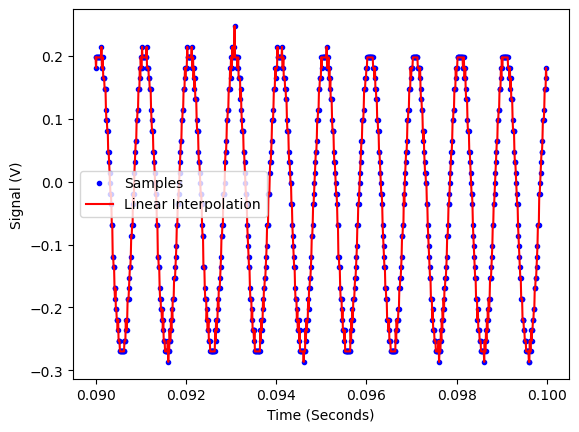

In [26]:
# plot the samples
plt.figure("Captured signal")
plt.plot(t_in[-1000:],data[0][-1000:],'b.')
plt.plot(t_in[-1000:],data[0][-1000:],'r-')
plt.legend(['Samples','Linear Interpolation'])
plt.xlabel('Time (Seconds)')
plt.ylabel('Signal (V)')

# save plot to an image
plt.savefig('Images/Scope ADALM2000.png')

plt.show()



In [25]:
# close the interface to the hardware
libm2k.contextClose(ctx)

The variable <code>Nb_periods</code> represents the number of periods of the sinusoid to be generated. The reason that the <code>math.floor</code> function is used is to round the value in parenthesis to the nearest integer up. This is requirement set by Python libraries when dealing with the ADALM-2000's buffer from which samples will be generated.

The above code saved the plot into a file on your local repository. Include it in your lab notebook by running the cell below.


*ANSWER:*

<figure>
<img src="Images/Scope ADALM2000.png" width="500">
<figcaption align = "center"></figcaption>
</figure>



## Spectrum Analyzer Exercises

Now that we have viewed the signals in the time-domain, let's take a look at their spectrum in the frequency domain. The setup is similar to the preceding section, except that now we will use the FieldFox RF Analyzer measurements.

_Note_: Each FieldFox RF Analyzer is an extremely sensitive and expensive instrument. Be very careful with the SMA connectors, as they can cost $1000. We also want to be very careful not to overload the inputs with signals that are too strong. Please make sure to always keep a 30 dB attenuator on its input port.

_Note_: We have a limited number of FieldFox RF Analyzers, so these will have to be shared among the student groups.

Once you have obtained a FieldFox, make the connections as indicated by the block diagram and figure below.

<figure>
<img src="Images/ADALM to Spectrum Analyzer Wiring BD.png" width="500">
<figcaption align = "center"></figcaption>
</figure>

<figure>
<img src="Images/ADALM to Spectrum Analyzer Wiring.jpg" width="700">
<figcaption align = "center"></figcaption>
</figure>

### Exercise 1.8: Reading FieldFox Settings via PyVISA

Run the script below to display the current settings on the RF Analyzer. Remember to replace the value for <code>VISA_ADDRESS</code> with the address for the FieldFox connected to your computer.

In [29]:
# sample code which works for Keysight FieldFox N9914B
import pyvisa as visa
import sys

rm = visa.ResourceManager('C:\\Windows\\System32\\visa64.dll')
try:
    VISA_ADDRESS = "USB0::0x2A8D::0x5C18::MY59221093::0::INSTR"  # set the resource string for your instrument
    inst = rm.open_resource(VISA_ADDRESS)  # open the connection
except visa.Error as ex:
    print('Couldn\'t connect to \'%s\', exiting now...' % VISA_ADDRESS)
    sys.exit()
inst.InputBufferSize = 1000000 # set the buffer size
inst.ByteOrder = 'littleEndian' # set the Byte order
inst.timeout = 10000 # set the timeout value

# Now control the instrument using SCPI commands.
# Refer to the instrument programming manual for your instrument for the correct SCPI commands for your instrument.
inst.write("INST:SEL 'SA';*OPC?")#Set the spectrum analyzer mode
a = inst.read()

inst.write('FREQ:SPAN?')#query Span
span = float(inst.read())
print('The span is ' + str(span) + ' Hz')

inst.write('BAND?') #query Resolution Bandwidth
bdw = float(inst.read())
print('The resolution bandwidth is ' + str(bdw) + ' Hz')

inst.write('FREQ:CENT?') #query Center Frequency
currRFFreq = float(inst.read())
print('The center frequency is ' + str(currRFFreq) + ' Hz')

inst.write('DISPlay:WINDow:TRACe:Y:RLEVel?')#query y axis reference level
y_ref = float(inst.read())
print('The y axis reference level is ' + str(y_ref) + ' dBm')

inst.write('SENS:SWE:POIN?')#query number of points in trace
numPoints = int(inst.read())
print('The number of points in trace is ' + str(numPoints))

# Close the VISA connection
inst.close()
rm.close()

The span is 6500000000.0 Hz
The resolution bandwidth is 5000000.0 Hz
The center frequency is 3250000000.0 Hz
The y axis reference level is 0.0 dBm
The number of points in trace is 401


The span, center frequency, and vertical axis reference level parameters are hopefully self-explanatory. Let's concern ourselves a little bit with the resolution bandwidth.

The spectrum analyzer's function is to find the power spectrum of its input signal as a function of different frequencies. It does so by calculating and then plotting each spectral component one after the other. The separation in frequency between adjacent measurements on a spectrum analyzer is called the *resolution bandwidth*. As this name name suggests, it is a measure of the resolution of the measured spectrum. The smaller the resolution bandwidth, the higher the number of measured frequencies.

It is worth noting that the amplitude on the spectrum analyzer (SA) are in dBm and not V (you will be asked to convert values from one scale to the other).

Given what you have learned about the operations of a spectrum analyzer, why might we set the resolution bandwidth to anything larger than its minimum value? Wouldn't this be best since it provides more accurate measurements?

*ANSWER:*

[It might be useful to set the resolution bandwidth to something larger than its minimum to get a faster updating image and save on computation. More resolution requires inputting more periods of the input signal]

### Excercise 1.9: Configuring FieldFox Settings via PyVISA

Run the following program to configure the spectrum analyzer. Remember to replace the value for <code>VISA_ADDRESS</code> with the address for the FieldFox connected to your computer.

In [32]:
# sample code that works for Keysight FieldFox N9914B
import pyvisa as visa
import sys
import time

rm = visa.ResourceManager('C:\\Windows\\System32\\visa64.dll')
try:
    VISA_ADDRESS = "USB0::0x2A8D::0x5C18::MY59221093::0::INSTR"  # set the resource string for your instrument
    inst = rm.open_resource(VISA_ADDRESS)  # open the connection
except visa.Error as ex:
    print('Couldn\'t connect to \'%s\', exiting now...' % VISA_ADDRESS)
    sys.exit()
inst.InputBufferSize = 1000000 # set the buffer size
inst.ByteOrder = 'littleEndian' # set the Byte order
inst.timeout = 10000 # set the timeout value

# Now control the instrument using SCPI commands.
# Refer to the instrument programming manual for your instrument for the correct SCPI commands for your instrument.
span = 0.4		# MHz, bandwidth
bdw = 1		# KHz, resolution bandwidth
currRFFreq = 0.25	# MHz, center frequency
y_ref = 20		# dBm, y reference

inst.write('SYST:PRES;*OPC?')#preset the instrument and wait for operation complete via the *OPC?
a = inst.read()
inst.write("INST:SEL 'SA';*OPC?")
a = inst.read()
inst.write('FREQ:SPAN ' + str(span) + ' MHz')#Set Span
inst.write('BAND ' + str(bdw) + ' KHz') #Set RES BW
inst.write('FREQ:CENT ' + str(currRFFreq) + ' MHz') #Set Center Frequency
time.sleep(1)
inst.write('DISPlay:WINDow:TRACe:Y:RLEVel ' + str(y_ref))#set y axis reference level
inst.write('SENS:SWE:POIN 601')

# Close the VISA connection
inst.close()
rm.close()

Now run the first cell on this notebook in Exercise 1.1 to generate a sinusoid at $250$ KHz.

Change the RF attenuation on the SA by pressing on "Scale/Ampl" button. What happens to the noise floor as you increase attenuation? What, do you believe, causes this effect?

*ANSWER:*

[As attenuation increases, amplitude of signal decreases and noise floor increases relative to the signal.]


### Exercise 1.10: Reading Data from FieldFox and Plotting it in Python

Similar to the oscilloscope, it is possible to record the trace produced by the spectrum analyzer with a Python script. 
Run the script below to grab data from the spectrum analyzer and generate a plot of the spectrum in Python.

The peak power is -32.3293991dBm
The average power is -57.74813951113644dBm


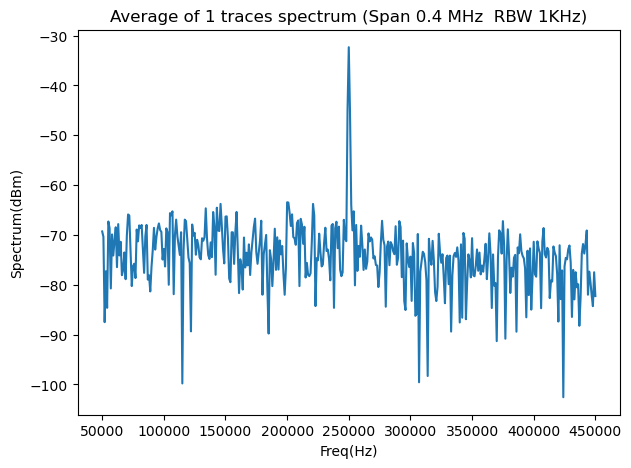

In [34]:
# sample code which works for Keysight FieldFox N9914B
import pyvisa as visa
import sys
import numpy as np
import matplotlib.pyplot as plt
import time

rm = visa.ResourceManager('C:\\Windows\\System32\\visa64.dll')
try:
    VISA_ADDRESS = "USB0::0x2A8D::0x5C18::MY59221093::0::INSTR"  # set the resource string for your instrument
    inst = rm.open_resource(VISA_ADDRESS)  # open the connection
except visa.Error as ex:
    print('Couldn\'t connect to \'%s\', exiting now...' % VISA_ADDRESS)
    sys.exit()
inst.InputBufferSize = 1000000 # set the buffer size
inst.ByteOrder = 'littleEndian' # set the Byte order
inst.timeout = 10000 # set the timeout value

# Now control the instrument using SCPI commands.
# Refer to the instrument programming manual for your instrument for the correct SCPI commands for your instrument.
span = 0.4		#MHz, bandwidth
bdw = 1			#KHz, resolution bandwidth
currRFFreq = 0.25	#MHz, center frequency
y_ref = 20		#dBm, y reference
ave_number = 1		#number of average traces

inst.write('SYST:PRES;*OPC?')#preset the instrument and wait for operation complete via the *OPC?
a = inst.read()
inst.write("INST:SEL 'SA';*OPC?")
a = inst.read()
inst.write('FREQ:SPAN ' + str(span) + ' MHz')#Set Span
inst.write('BAND ' + str(bdw) + ' KHz') #Set RES BW
inst.write('FREQ:CENT ' + str(currRFFreq) + ' MHz') #Set Center Frequency
time.sleep(1)
inst.write('DISPlay:WINDow:TRACe:Y:RLEVel ' + str(y_ref))#set y axis reference level
inst.write('SENS:SWE:POIN?')#query number of points in trace
numPoints = int(inst.read())
inst.write('SENS:FREQ:START?')#query start frequency
startFreq = float(inst.read())
inst.write('SENS:FREQ:STOP?')#query stop frequency
stopFreq = float(inst.read())
x = np.linspace(startFreq, stopFreq, numPoints)
data_array = np.zeros((1, numPoints))

inst.write('TRAC1:TYPE AVG')
inst.write('SENSe:AVERage:TYPE AUTO')#set average mode
inst.write('SENSe:AVERage:COUNt ' + str(ave_number))#set average count

inst.write('INIT:CONT OFF;*OPC?')#set trigger mode to hold for trigger synchronization
a = inst.read()
inst.write('INIT:IMM;*OPC?')#assert a single trigger and wait for trigger complete
a = inst.read()
inst.write('INIT:REST;*OPC?')
a = inst.read()

inst.write('TRAC1:DATA?')#query the response data
data = inst.read()
data_array = np.array(data.split(',')).astype('float64') #use split to turn long string to an array of values
print('The peak power is ' + str(max(data_array)) + 'dBm')
average_power = 10*np.log10(np.mean(np.power(10, data_array/10)))
print('The average power is ' + str(average_power) + 'dBm')

inst.write('INIT:CONT ON;*OPC?')
a = inst.read()
# Close the VISA connection
inst.close()
rm.close()


# Plot the spectrum
plt.figure(figsize=(7, 5))
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectrum(dBm)')
plt.title('Average of '+ str(ave_number)+' traces spectrum (Span ' + str(span) + ' MHz ' + ' RBW ' + str(bdw) + 'KHz)')
plt.plot(x, data_array)
plt.savefig('Images/Spectrum Analyzer Sine Screen Capture.png')
plt.show()

*ANSWER:*

<figure>
<img src="Images/Spectrum Analyzer Sine Screen Capture.png" width="700">
<figcaption align = "center"></figcaption>
</figure>

### Exercise 1.11: Capturing a Screenshot of the Spectrum Analyzer

To capture a screeshot of the FieldFox RF Analyzer, run the code cell below.

In [36]:
# screen shot sample code which works for Keysight FieldFox N9914B
import pyvisa as visa
import sys

rm = visa.ResourceManager('C:\\Windows\\System32\\visa64.dll')
try:
    VISA_ADDRESS = "USB::0x2A8D::0x5C18::MY59221093::INSTR"  # set the resource string for your instrument
    inst = rm.open_resource(VISA_ADDRESS)  # open the connection
except visa.Error as ex:
    print('Couldn\'t connect to \'%s\', exiting now...' % VISA_ADDRESS)
    sys.exit()
inst.timeout = 10000 # set the timeout value

inst.write('MMEM:STOR:IMAG "my.png"') # save the screen shot in instrument drive
capture = inst.query_binary_values('MMEM:DATA? "my.png"', container = list, datatype = 'c')
# Write the data in specified file
with open('Images/FieldFox_sin_screen.png', 'wb') as fp:
    for byte in capture:
        fp.write(byte)
inst.write('MMEM:DEL "my.png"') # delete the screen shot in instrument drive
# Close the VISA connection
inst.close()
rm.close()

Record the file in your report as you did before by running the cell below.

*ANSWER:*

<figure>
<img src="Images/FieldFox_sin_screen.png" width="700">
<figcaption align = "center"></figcaption>
</figure>

### Exercise 1.12: Generating a Square Wave and Estimating its Spectrum with the Oscilloscope

In this exercise, we will use the code you developed for Exercise 1.5 of Prelab 1. Copy your working code from that exercise into the two code cells below.

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# fseries: helper function to compute samples of a Fourier Series approximation given
#    K: the order of the Fourier Series approximation
#    a: the array of Fourier coefficients a_k for k=0,+/-1,+/-2,...,+/-K
#    f_0: the fundamental frequency [Hz]
#    f_2: the sampling frequency [Hz]
#    t: time values at which to generate samples [seconds]
def fseries(K,a,f_0,f_s,t):
    y_K = np.zeros(np.size(t), dtype=complex) #add complex dtype because interpreter got mad
    
    #loop through, keeping index
    for index, coeff in enumerate(a):
    
        #translate index to k
        k = index-K #subtract k to convert e.g. at index 0, k = -K
        
        T_0 = 1/f_0
        
        #copy formula, adding to y_K
        y_K += coeff * np.exp(1j*((2*np.pi*k)/(T_0)) * t)

    return y_K

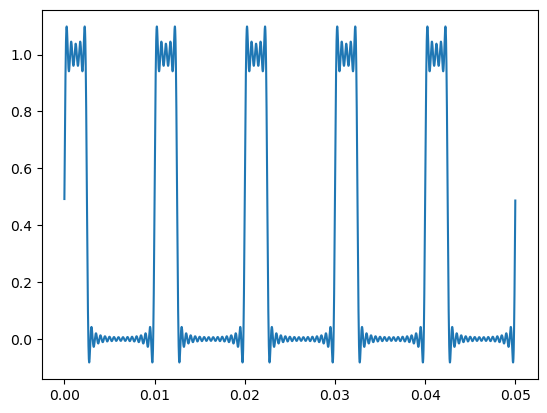

In [78]:
import numpy as np
import matplotlib.pyplot as plt

def coeff_gen(k):
    return 0.25 if k == 0 else ((1-np.cos((np.pi*k)/2) + 1j*np.sin((np.pi*k)/2))/(1j*2*np.pi*k)) #return function from question 1.5a


# just change and re-run to make new graphs
K = 20
f_0 = 100
f_s = 750e03
cycles = 5

#make time based on cycles
t = np.arange(0, cycles*(1/f_0), 1/f_s)

#generate coefficients
a_k = [coeff_gen(k-K) for k in range(K*2 + 1)] #list comprehensions are good

#construck y from fseries
y_K = fseries(K, a_k, f_0, f_s, t)

plt.plot(t, y_K)

Save your computed samples of the waveform into the variable <code>buffer</code> for later use.

In [79]:
buffer = y_K

#### Question 1.12a:

Without taking a measurement of the spectrum of the signal generated by the code above, what do you expect its spectrum will look like? How many peaks will you observe for positive frequencies, and why?

*ANSWER:*

[We will have peaks at odd-valued frequencies -> f_0/3, f_0/4, etc. we will see about 20 peaks because we used 20 fourier series coefficients]

Please type your answer here.

#### Question 1.12b:

Estimate the frequencies of the first 5 spectrum peaks in the spectrum.

*ANSWER:*

[f_0, 2f_0, 3f_0, 5f_0, 6f_0]

#### Question 1.12c:

Now connect the ADALM-2000 to the oscilloscope as you did in Exercise 1.1. Then run the three cells below. The first will generate the square wave on the ADALM-2000, the second will transfer a large set of samples from the oscilloscope and plot the waveform, and the third will use the FFT to compute an estimate of the power spectrum of the waveform. We note that we are using the oscilloscope instead of the ADALM-2000 to sample the waveform in order to obtain a large set of samples and increase the frequency resolution of the spectrum.

In [80]:
import libm2k
import numpy as np
import math
import time
import matplotlib.pyplot as plt

# check that the hardware is plugged in
buffer = np.real(y_K)
uri = libm2k.getAllContexts()
if(len(uri) == 0):
    libm2k.contextCloseAll()

# open the hardware and calibrate it
ctx=libm2k.m2kOpen()
ctx.calibrateDAC()
aout=ctx.getAnalogOut()

fs_out = 750e03			# output(DAC) sampling rate in HZ
Ts_out = 1.0 / fs_out	# sampling period in seconds

# configure the output channel on the ADALM-2000
channel = 0	# 0 or 1 corresponding to I or Q
aout.setSampleRate(channel, fs_out)
aout.enableChannel(channel, True)
aout.setCyclic(True)

print(buffer)

# push the data to the ADALM-2000
aout.push(channel,buffer)

[0.49206191 0.49739627 0.50273238 ... 0.47607419 0.48140037 0.48672977]


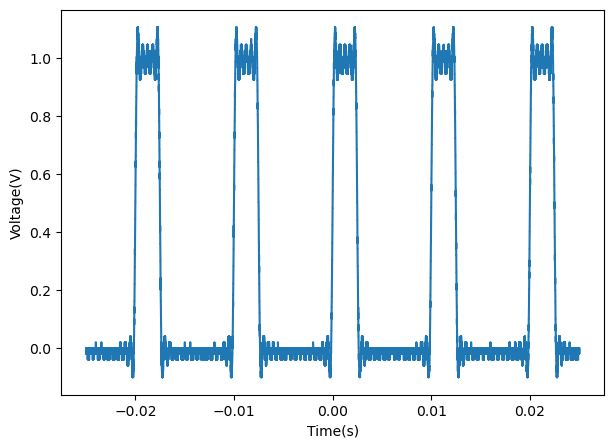

In [83]:
# sample code which works for Keysight Oscilloscope MSOX3014T
import pyvisa as visa
import sys
import numpy as np
import matplotlib.pyplot as plt

rm = visa.ResourceManager("C:\\Windows\\System32\\visa64.dll")
try:
    VISA_ADDRESS = "USB::0x2A8D::0x1778::MY59241120::INSTR"  # set the resource string for your instrument
    inst = rm.open_resource(VISA_ADDRESS)  # open the connection
except visa.Error as ex:
    print('Couldn\'t connect to \'%s\', exiting now...' % VISA_ADDRESS)
    sys.exit()

inst.InputBufferSize = 10000000 # set the buffer size
inst.ByteOrder = 'littleEndian' # set the Byte order
inst.timeout = 10000 # set the timeout value


# Capture data
inst.write('DIGitize CHANnel1') # tell instrument to digitize channel 1
inst.write('WAVeform:SOURce CHANnel1') # specify data from Channel 1
inst.write('WAVeform:POINts?')
num_points = int(inst.read())
inst.write('WAVeform:FORMat WORD') # get the data back as a WORD(i.e. int16), other options are ASCII and BYTE
inst.write('WAVeform:BYTeorder LSBF') # set the byte order on the instrument as well

# Read the data in specified format
data = inst.query_binary_values('WAVeform:DATA?', datatype = 'h', is_big_endian = False, container = np.array)
x_inc = float(inst.query('WAV:XINC?')) # time difference between different data points
x_or = float(inst.query('WAV:XOR?')) # always the first data point in memory
y_inc = float(inst.query('WAV:YINC?')) # voltage diff between data points
y_or = float(inst.query('WAV:YOR?')) # voltage at center screen
y_ref = float(inst.query('WAV:YREFERENCE?')) # specifies the data point where y-origin occurs
# Generate X&Y data
t = np.linspace(x_or, x_or + (num_points + 1)*x_inc, num_points)
data = (data - y_ref).astype('h') * y_inc + y_or
# Close the VISA connection
inst.close()
rm.close()
# Plot the waveform
plt.figure(figsize=(7, 5))
plt.plot(t, data)
plt.xlabel('Time(s)')
plt.ylabel('Voltage(V)')
plt.savefig('Images/oscilloscope_plot_square_wave.png')
plt.show()

*TBD:* Delete lines immediately below and set the time scale on the scope automatically in the script above.

<span style='color:green;font-weight: bold'>Before running the script for the oscilloscope, change the time scale on it to 750 us/division. Ask yourself: why do you think we made the change?</span>

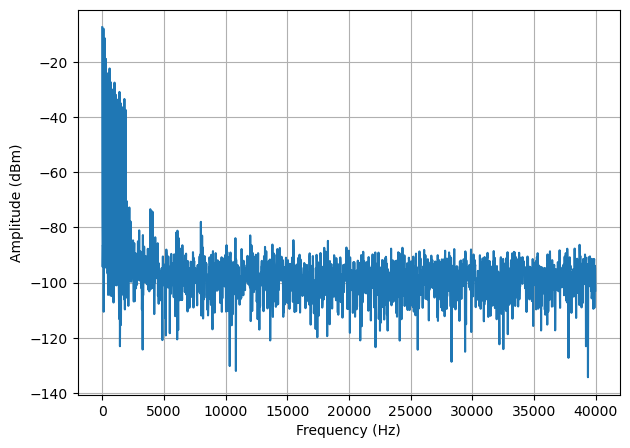

In [84]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt
# Number of sample points
N = num_points
# sample spacing
T = x_inc
x = np.linspace(0.0, N*T, N, endpoint=False)
#y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(data)
xf = fftfreq(N, T)#[:N//2]

plt.figure(figsize=(7, 5))
absica = xf
ordinate = 2.0/N * np.abs(yf)
#ordinate = 2.0/N * np.abs(yf[0:N//2])
plt.plot(absica[0:2000], 10*np.log(ordinate[0:2000]))
plt.savefig('Images/spectrum_square_wave_fft.png')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dBm)')
plt.grid()
plt.show()

Attach both the plot produced by the oscilloscope and the spectrum to your submission by running the two cells below.

*ANSWER:*

<figure>
<img src="Images/oscilloscope_plot_square_wave.png" width="700">
<figcaption align = "center"></figcaption>
</figure>

<figure>
<img src="Images/spectrum_square_wave_fft.png" width="700">
<figcaption align = "center"></figcaption>
</figure>

#### Question 1.12d:

How many peaks does you observe in the computed spectrum? Is this consistent with your expectations in Questions 1.12a and 1.12b? Why or why not?

*ANSWER*:

[We observe 15 peaks. We expected 20 peaks due to having 20 fs coefficients]

### Exercise 1.13: Determining the Equivalent Interpolation Frequency Response of the DAC

In this exercise, we will experimentally determine the maximum frequency of a sinusoid that can be can emitted by the DAC of the ADALM, $\text{max}(f_{s,m})$. We will also measure magnitude of the frequency response of equivalent filter for transmission, $|H_{DAC}(f)|.$

#### Question 1.13a:

If the DAC used ideal band-limited interpolation and the sampling rate of the DAC was $75$ MSPS or $75$ MHz, what would you expect $\text{max}(f_{s,m})$ to be?

*ANSWER*:

$\text{max}(f_{s,m}) = [37.5]$ MHz

#### Question 1.13b:

As you saw in Prelab 1, the actual maximum frequency is less than the ideal value value due to the non-ideal interpolation filter $H_{DAC}(f)$. Here we aim to measure the magnitude response of that filter and develop a rule of thumb for a practical value of $\text{max}(f_{s,m})$.

Re-connect the output of the ADALM-2000 with the RF Analyzer as you did in Exercise 1.8. Select SA (for spectrum analyzer) mode. Set the center frequency to 0 Hz and the frequency span to 1 MHz (use the Freq/Dist button to do that). To be able to display the spectrum with more precision, reduce the resolution bandwidth to 10 kHz (BW button). Run the script below which sends a 250kHz tone (or sinusoid) out of the ADALM.

Run the code below, copied from Exercise 1.1, to generate a sinusoid from the ADALM-2000.

In [108]:
# import necessary libraries
import libm2k
import numpy as np
import math
import time


# define global parameters
fs_out = 75e06      # output(DAC) sampling rate in HZ
Ts_out = 1.0 / fs_out   # sampling period in seconds
fm_s = 40e06     # sinusoidal wave frequency in HZ
Tm_s = 1.0 / fm_s   # period of the sinusoidal wave in seconds

# check that the hardware is plugged in
uri = libm2k.getAllContexts()
if(len(uri) == 0):
    libm2k.contextCloseAll()

# open the hardware and calibrate it
ctx=libm2k.m2kOpen()
ctx.calibrateDAC()
aout=ctx.getAnalogOut()

# compute a an integer number of periods of the sinusoid
# with total buffer size less than 4M samples
periods=math.floor(4e6/fs_out/Tm_s)

# generate samples
t=np.arange(0,periods*Tm_s,Ts_out)
buffer = 0.25*np.sin(2*np.pi*fm_s*t)

# configure the output channel on the ADALM-2000
channel = 0	# 0 or 1 corresponding to I or Q
aout.setSampleRate(channel, fs_out)
aout.enableChannel(channel, True)
aout.setCyclic(True)

# push the data to the ADALM-2000
aout.push(channel,buffer) # Push the buffer to channel of the output

Then, to find the amplitude, use markers on the RF Analyzer:

- Press on the "markers" button located on the left of the device.
- Press on the button located under the "Peak" tab that is shown the screen.
- Use the rotary knob to move the marker to the peak at $250$ kHz.


#### Question 1.13c:

What amplitude do you read on the upper right corner on the screen?

*ANSWER:*

$X_{250\text{kHz}}(250 \times 10^3) = [-32.03]$ dBm

#### Question 1.13d:

Compare your answer to Exercise 1.13c to your answer in Exercise 1.1 How can you explain the difference? (_Hint:_ Review Prelab Exercise 1.4.)

*ANSWER:*

[Our dbm here is lower than before. This is due to the -30dB attenuator physically attatched to the input of the field fox]


#### Question 1.13e:

Change the frequency of the sinusoid, $f_{ms}$, to $20$ MHz in the code above and run it again. To be able to see the main peak, increase the frequency range of the spectrum analyzer to $125$MHz. What is its amplitude of the fundamental frequency component?

*ANSWER:*

[-34.36 dBm]

_Note_: The other peaks that appear on the spectrum analyzer are due to the non-idealities of the internal components of the ADALM and can be ignored for now.

#### Question 1.13f:

Re-execute the above code to generate sinusoids of different frequencies and measure the output power on the spectrum analyzer. Use these measurements to estimate the gain of $H_{DAF}(f)$, or the magnitude of the frequency response $|H_{DAC}(f)|$, as a function of frequency. Report your results in the table below.

As the frequency of the input sinsoid gets closer to your answer in Exercise 1.13a, what do you observe just above half the sampling frequency ($f_s/2$)? Explain what is causing this phenomenon.

*ANSWER:*

| Frequency  | $|H_{DAC}(f)|^2$  dB |
|--------|--------|
| 1 MHz  | -32.1   |
| 2 MHz  | -32.14   |
| 5 MHz  | -32.32   |
| 10 MHz | -32.88   |
| 15 MHz | -33.6   |
| 20 MHz | -40.5   |
| 25 MHz | -35.4   |
| 27 MHz | -35.8   |
| 30 MHz | -36.5   |
| 32 MHz | -37   |
| 35 MHz | -39   |
| 37.5 MHz | -100 (noise)   |
| 40 MHz | -53   |

[lower power at above f_s/2 is caused by an alias of the original signal being picked up rather than a pure tone. at exactly f_s, there is zero signal picked up.]

#### Question 1.13g:

Given your measurements in Exercise 1.13f, and assuming $|H_{DAC}(0)|^2 = 0$ dB, what do you estimate is the largest frequency that can be used in practice such that $|H_{DAC}(f)|^2 > -2$ dB for $f_{s,out}=75$ MHz? (This value roughly corresponds to the frequency $f_{s,out}/(2(1+\alpha))$ discussed in the Prelab.)

*ANSWER*:

[This value is around 25 MHz]

_Note:_ Be sure to release the interface to the ADALM-2000 hardware by executing the cell below.

In [ ]:
libm2k.contextClose(ctx)